# Titanic Predicting the surivial rate - a classification problem

# Data columns provided

Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

# Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


# Steps to take

1. get the files
2. check the relationship between input and output through graphs
3. check missing data and preprocess
4. try out different classifier and hyperparamter tuning
5. focus on one model and hyperparamter
6. export output file

## Step 1. get the files

In [2]:
# set the file path
titanic_test_file = '../input/titanic/test.csv'
titanic_train_file = '../input/titanic/train.csv'

# open pd file
test = pd.read_csv(titanic_test_file, index_col='PassengerId')
train = pd.read_csv(titanic_train_file, index_col='PassengerId')

## Step 2.  check the relationship between input and output through graphs


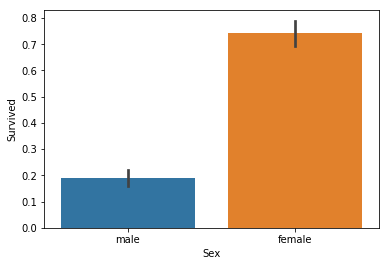

In [3]:
import seaborn as sns
import matplotlib. pyplot as plt

sns.barplot(x=train['Sex'],y=train['Survived'])
plt.show()

# more females surviving than males, but are there more female in general?

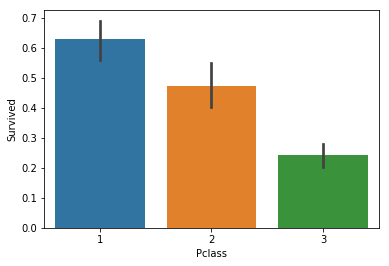

In [4]:
sns.barplot(x=train['Pclass'],y=train['Survived'])
plt.show()

# Higher class, higher survival rate

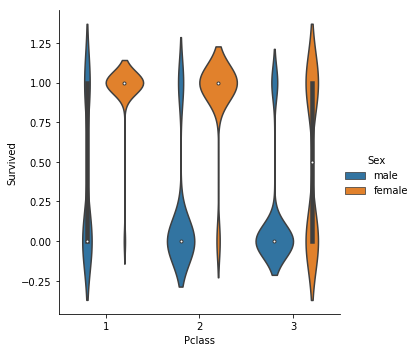

In [5]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", kind="violin", data=train)
plt.show()

# 1st calss female is almost guaranteed to survived

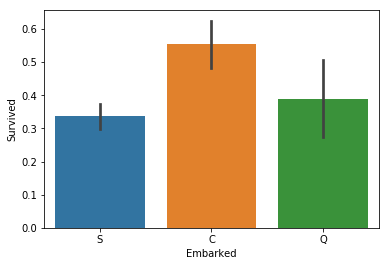

In [6]:
sns.barplot(x=train['Embarked'],y=train['Survived'])
plt.show()

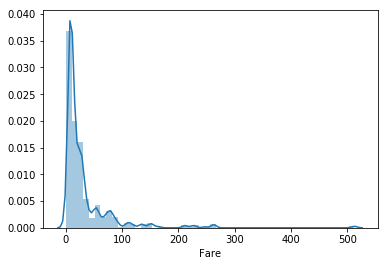

In [7]:
sns.distplot(a=train['Fare'])
plt.show()

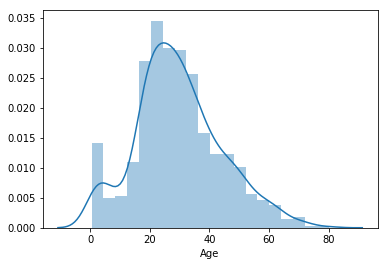

In [8]:
sns.distplot(a=train['Age'])
plt.show()

## Step 3. preprocess

In [9]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [10]:
test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [11]:
train[['Last','rest']] = train.Name.str.split(",",expand=True)
train[['Title','end']] = train.rest.str.split(".",n=1,expand=True)
age_median = train[['Age']].median()
fare_median = train[['Fare']].median()
train[["Age"]] = train[["Age"]].fillna(age_median)
train[["Embarked"]] = train[["Embarked"]].fillna('Unknown')
train['fam_size'] = train.apply(lambda row: row.SibSp + row.Parch, axis=1)

title_names = (train['Title'].value_counts() < 20) # true false mask with title name as index
train['Title'] = train['Title'].apply(lambda x: 'High' if title_names.loc[x] == True else x)
train.Title.value_counts()


# probability not worth having title as a column, since the info is mostly encoded in the sex and fare price
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
Last          0
rest          0
Title         0
end           0
fam_size      0
dtype: int64

In [12]:
test[['Last','rest']] = test.Name.str.split(",",expand=True)
test[['Title','end']] = test.rest.str.split(".",n=1,expand=True)
test[["Age"]] = test[["Age"]].fillna(age_median)
test[["Fare"]] = test[["Fare"]].fillna(fare_median)
test[["Embarked"]] = test[["Embarked"]].fillna('Unknown')
test_names = (test['Title'].value_counts() < 20) # true false mask with title name as index

test['Title'] = test['Title'].apply(lambda x: 'High' if test_names.loc[x] == True else x)
test['fam_size'] = test.apply(lambda row: row.SibSp + row.Parch, axis=1)

print(test.isnull().sum())

Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       327
Embarked      0
Last          0
rest          0
Title         0
end           0
fam_size      0
dtype: int64


In [13]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last,rest,Title,end,fam_size
PassengerId,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Kelly,Mr. James,Mr,James,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Wilkes,Mrs. James (Ellen Needs),Mrs,James (Ellen Needs),1
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Myles,Mr. Thomas Francis,Mr,Thomas Francis,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Wirz,Mr. Albert,Mr,Albert,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Hirvonen,Mrs. Alexander (Helga E Lindqvist),Mrs,Alexander (Helga E Lindqvist),2


In [14]:
useful_columns_train=['Survived','Pclass','Sex','Age','Fare','Embarked','fam_size']
useful_columns_test=['Pclass','Sex','Age','Fare','Embarked','fam_size']


train_sel = train[useful_columns_train]
test_sel = test[useful_columns_test]

In [15]:
test_sel.head()

,Pclass,Sex,Age,Fare,Embarked,fam_size
PassengerId,,,,,,
892,3,male,34.5,7.8292,Q,0
893,3,female,47.0,7.0000,S,1
894,2,male,62.0,9.6875,Q,0
895,3,male,27.0,8.6625,S,0
896,3,female,22.0,12.2875,S,2


In [16]:
# generate binary values using get_dummies
dummies_train = pd.get_dummies(train_sel, columns=["Sex","Embarked"] )

# generate binary values using get_dummies
dummies_test = pd.get_dummies(test_sel, columns=["Sex","Embarked"])

In [17]:
dummies_test['Embarked_Unknown'] = 0
dummies_test.describe()

,Pclass,Age,Fare,fam_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0
mean,2.265550,29.805024,35.576535,0.839713,0.363636,0.636364,0.244019,0.110048,0.645933,0.0
std,0.841838,12.667969,55.850103,1.519072,0.481622,0.481622,0.430019,0.313324,0.478803,0.0
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,23.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,3.000000,28.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0
75%,3.000000,35.750000,31.471875,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0
max,3.000000,76.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [18]:
y = dummies_train['Survived']
X = dummies_train.iloc[:,1:]

test_X = dummies_test

In [20]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2)

print("train_X Shape: {}".format(train_X.shape))
print("valid_X Shape: {}".format(valid_X.shape))
print("test_X Shape: {}".format(test_X.shape))

train_X Shape: (712, 10)
valid_X Shape: (179, 10)
test_X Shape: (418, 10)


## Step 4. try out different classifier and hyperparamter tuning


In [27]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

import eli5
from eli5.sklearn import PermutationImportance


model = RandomForestClassifier(n_estimators=200)

model.fit(train_X,train_y)

train_pred = model.predict(train_X)
valid_pred = model.predict(valid_X)
    
print("training misclassified:",(train_y-train_pred).sum())
print("validation misclassified:",(valid_y-valid_pred).sum())
print("training accuracy is %2.3f" % accuracy_score(train_y,train_pred))
print("validaiton accuracy is %2.3f" % accuracy_score(valid_y,valid_pred))
print('Precision:%.3f'%precision_score(y_true=valid_y,y_pred=valid_pred))
print('Recall:%.3f'%recall_score(y_true=valid_y,y_pred=valid_pred))
print('F1:%.3f'%f1_score(y_true=valid_y,y_pred=valid_pred))


perm = PermutationImportance(model).fit(train_X, train_y)
eli5.show_weights(perm, feature_names = train_X.columns.tolist())
    

training misclassified: 4
validation misclassified: -6
training accuracy is 0.983
validaiton accuracy is 0.765
Precision:0.667
Recall:0.727
F1:0.696


Weight,Feature
0.1534 ± 0.0192,Age
0.1438 ± 0.0148,Fare
0.1138 ± 0.0146,Pclass
0.0924 ± 0.0116,Sex_female
0.0823 ± 0.0038,Sex_male
0.0753 ± 0.0119,fam_size
0.0323 ± 0.0018,Embarked_S
0.0185 ± 0.0048,Embarked_C
0.0090 ± 0.0038,Embarked_Q
0 ± 0.0000,Embarked_Unknown


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(),
                        LogisticRegression(solver='lbfgs'))

pipe_lr.fit(train_X, train_y)
valid_pred = pipe_lr.predict(valid_X)
print('Test Accuracy: %.3f' % pipe_lr.score(valid_X,valid_y))

Test Accuracy: 0.765


In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(train_X,train_y)

train_pred = knn.predict(train_X)
valid_pred = knn.predict(valid_X)
    
print("training misclassified:",(train_y-train_pred).sum())
print("validation misclassified:",(valid_y-valid_pred).sum())
print("training accuracy is %2.3f" % accuracy_score(train_y,train_pred))
print("validaiton accuracy is %2.3f" % accuracy_score(valid_y,valid_pred))


training misclassified: 104
validation misclassified: 31
training accuracy is 0.851
validaiton accuracy is 0.715


In [25]:
from sklearn.linear_model import SGDClassifier

def SGD_model(train_X,train_y,valid_X,valid_y):
    model = SGDClassifier()
    model.fit(train_X,train_y)

    train_pred = model.predict(train_X)
    valid_pred = model.predict(valid_X)

    print("training misclassified:",(train_y-train_pred).sum())
    print("validation misclassified:",(valid_y-valid_pred).sum())
    print("training accuracy is %2.3f" % accuracy_score(train_y,train_pred))
    print("validaiton accuracy is %2.3f" % accuracy_score(valid_y,valid_pred))

    
SGD_model(train_X,train_y,valid_X,valid_y)

training misclassified: 269
validation misclassified: 66
training accuracy is 0.619
validaiton accuracy is 0.631


## Step 5. focus on one model and hyperparamter
* We will use the Random Forest Classifier
* Disgard Embark since the influence it has is not high

In [26]:
useful_columns2=['Survived','Pclass','Sex','Age','Fare','fam_size']
useful_columns2_test=['Pclass','Sex','Age','Fare','fam_size']


train_sel2 = train[useful_columns2]
test_sel2 = test[useful_columns2_test]

# generate binary values using get_dummies
dummies_train2 = pd.get_dummies(train_sel2, columns=["Sex"] )

# generate binary values using get_dummies
dummies_test2 = pd.get_dummies(test_sel2, columns=["Sex"])

y2 = dummies_train2['Survived']
X2 = dummies_train2.iloc[:,1:]

test_X2 = dummies_test2

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200)

model.fit(X2,y2)

test_pred = model.predict(test_X2)
    


## Step 6. get output file and submit

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_y2.index,
        "Survived": test_pred
    })
submission.to_csv('submission.csv', index=False)